In [3]:
#import pytesseract
#from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
#import csv

In [4]:
image_file = "C:/Users/49176/OneDrive/Desktop/OCR/table 2.png"

# Basic functions for Image Preprocessing with open cv

In [49]:
# load image with open cv
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Fehler: Bild konnte nicht geladen werden.")
    else:
        print("Bild erfolgreich geladen.")
    return image

In [50]:
# display image

def display_image(image, title="Image"):
    plt.figure(figsize=(12, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    

In [51]:
# produce a grayscale image
def grayscale_image(image):  
    grayscaled_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return grayscaled_image

In [52]:
# invert an image
def invert_image(image):
    inverted_image = cv2.bitwise_not(image)
    return inverted_image

In [53]:
# create a binary image
def binary_image(image):
    thresh, bin_image = cv2.threshold(image, 170, 240, cv2.THRESH_BINARY)  #there is also cv2.THRESH_OTSU
    return bin_image

In [54]:
# erode image
def erode_image(image):
    image = cv2.bitwise_not(image)
    kernal = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernal, iterations = 1)
    image = cv2.bitwise_not(image)
    return image

In [55]:
# dilate image
def dilate_image(image):
    image = cv2.bitwise_not(image)
    kernal = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernal, iterations = 1)
    image = cv2.bitwise_not(image)
    return image

In [56]:
# blur image
def blur_image(image):
    kernal=(5,5)
    blurred_image = cv2.GaussianBlur(image, kernal, sigmaX=0)
    return blurred_image

# specific functions for better OCR results

In [75]:
# find countours (binary image)
def find_contours(bin_image):
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy


In [76]:
# find countours with edges
def find_contours_with_canny_edges(bin_image):
    edges = cv2.Canny(bin_image, 100, 200)
    contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy, edges  

In [101]:
# remove horizontal lines 
def remove_horizontal_lines(image):
    image = cv2.bitwise_not(image)
    horizontal_kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    horizontal_lines = cv2.morphologyEx(image, cv2.MORPH_OPEN, horizontal_kernal)
    no_horizontal_lines_image = cv2.subtract(image, horizontal_lines)
    no_horizontal_lines_image = cv2.bitwise_not(no_horizontal_lines_image)
    return no_horizontal_lines_image

In [102]:
# remove vertical lines 
def remove_vertical_lines(image):
    image = cv2.bitwise_not(image)
    vertical_kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    vertical_lines = cv2.morphologyEx(image, cv2.MORPH_OPEN, vertical_kernal)
    no_vertical_lines_image = cv2.subtract(image, vertical_lines)
    no_vertical_lines_image = cv2.bitwise_not(no_vertical_lines_image)
    return no_vertical_lines_image

Testing area

In [103]:
image = load_image(image_file)
grayed_image = grayscale_image(image)
inverted_image = invert_image(grayed_image)
bin_image = binary_image(grayed_image)
eroded_image = erode_image(image)
dilated_image = dilate_image(image)
blured_image = blur_image(image)
image_without_horizontal_lines = remove_horizontal_lines(image)
image_without_vertical_lines = remove_vertical_lines(image)

Bild erfolgreich geladen.


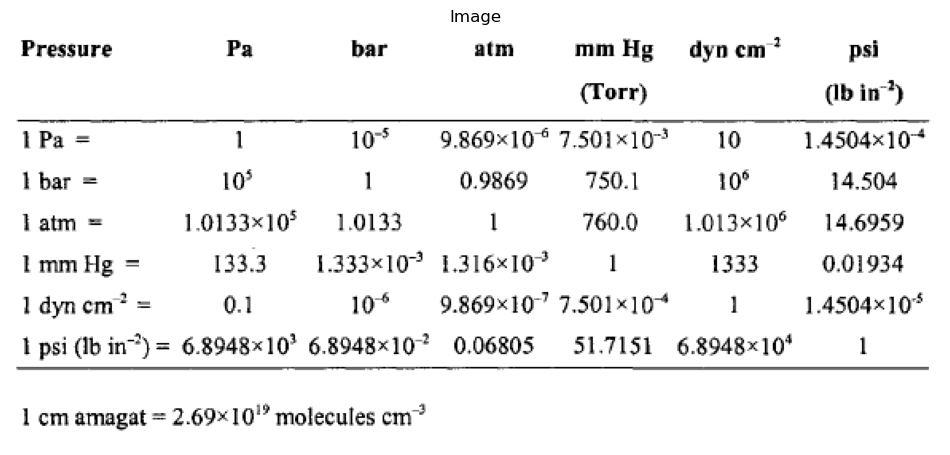

In [78]:
display_image(image)

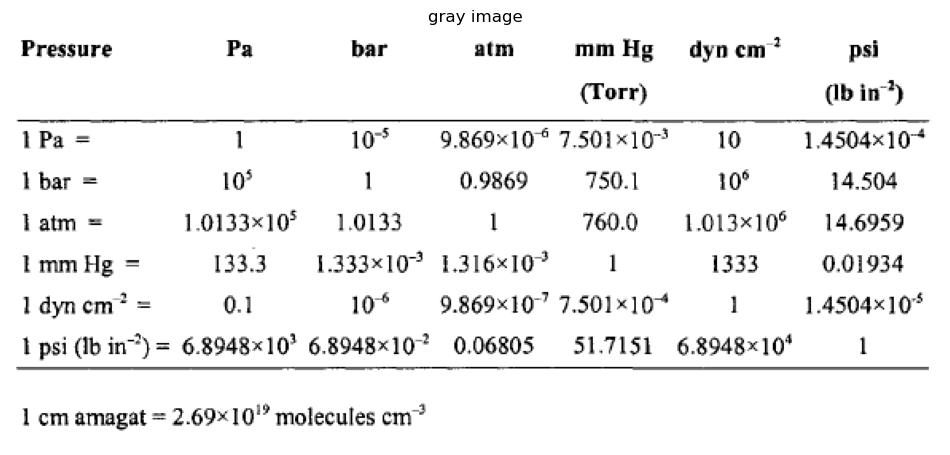

In [79]:
display_image(grayed_image,"gray image")

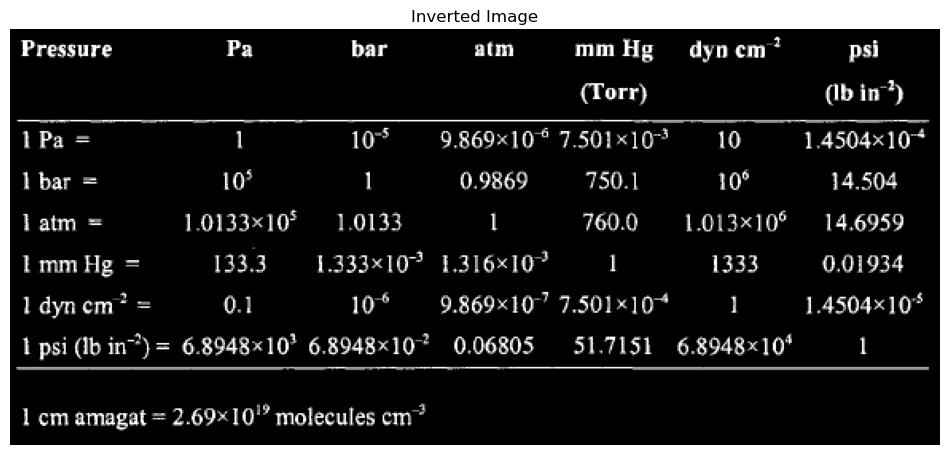

In [80]:
display_image(inverted_image,"Inverted Image")

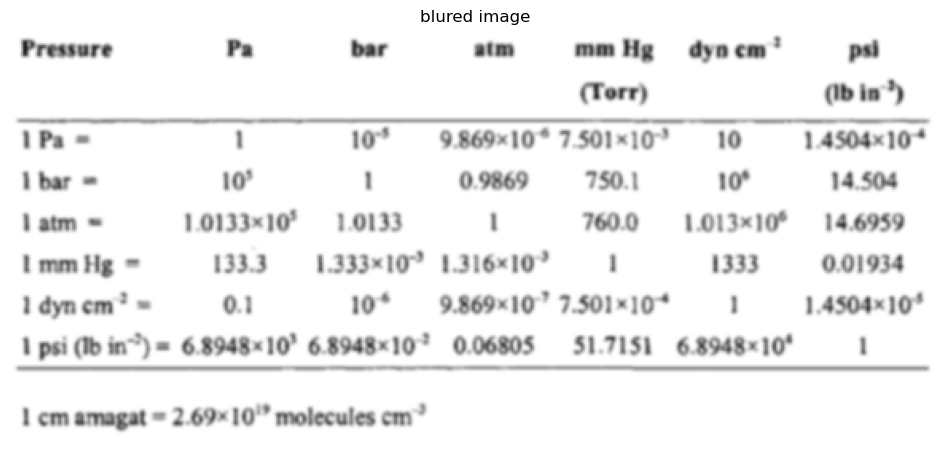

In [81]:
display_image(blured_image,"blured image")

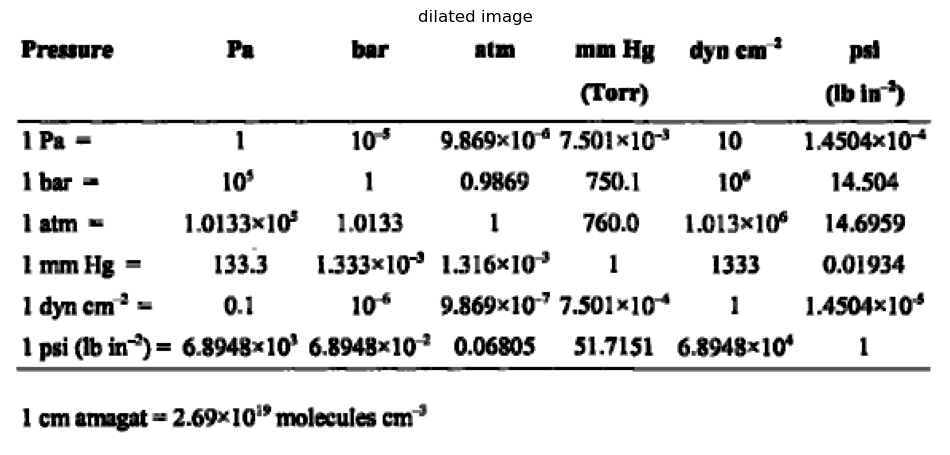

In [82]:
display_image(dilated_image,"dilated image")

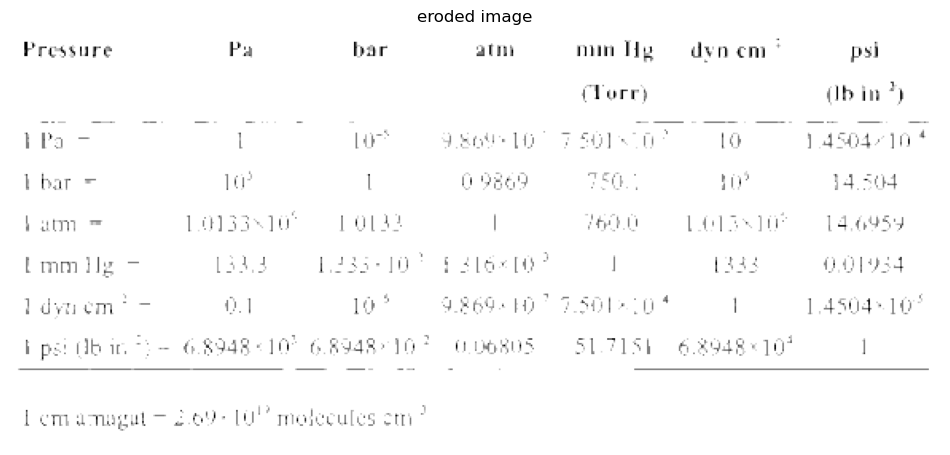

In [83]:
display_image(eroded_image,"eroded image")

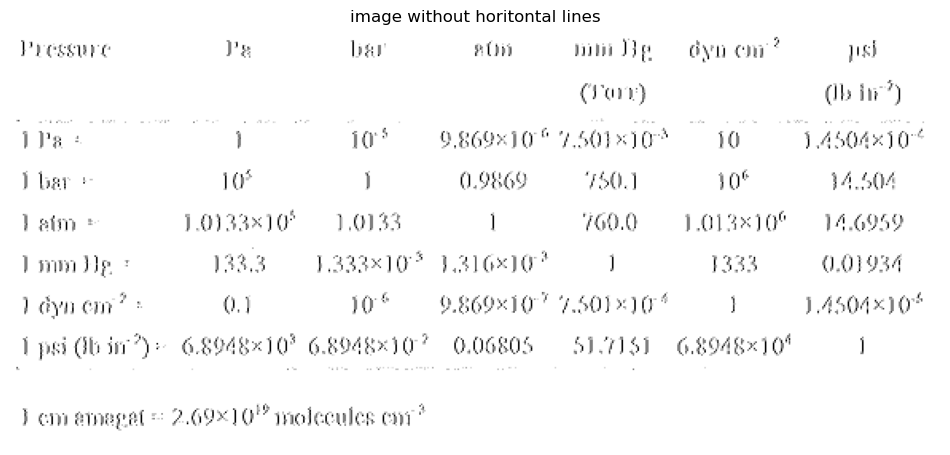

In [107]:
display_image(image_without_horizontal_lines,"image without horitontal lines")

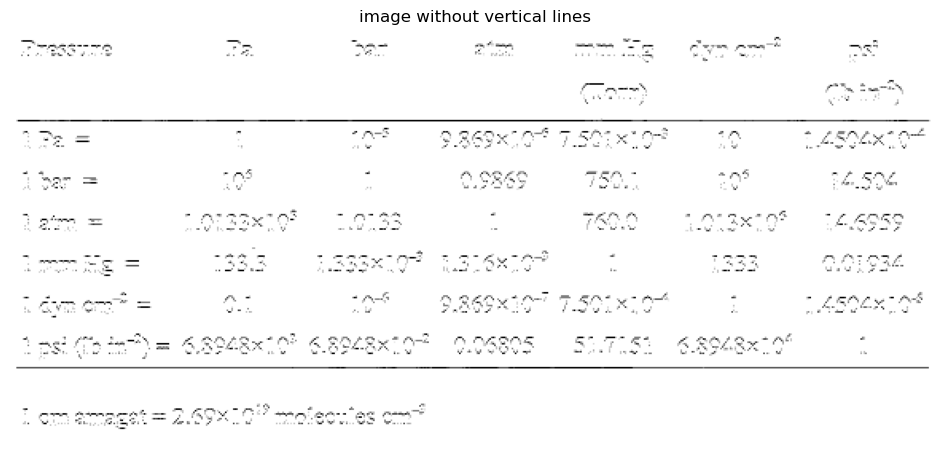

In [106]:
display_image(image_without_vertical_lines,"image without vertical lines")